In [323]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import yfinance as yf
from scipy.optimize import minimize

In [324]:
%run optimization_criterions.ipynb

In [325]:
timezone = pytz.timezone("Europe/Paris")
time_from = datetime.datetime(2000, 1, 1, tzinfo = timezone)
time_to = datetime.datetime.now(timezone) + datetime.timedelta(days=1)
if mt5.initialize():
    # Obtener portfolio
    symbols = mt5.symbols_get()
    list_tickers = [symbol.name for symbol in symbols if "ETF" in symbol.path]
    database = [mt5.copy_rates_range(ticker, mt5.TIMEFRAME_D1, time_from, time_to) for ticker in list_tickers]
    df_portfolio = pd.DataFrame()
    for ticker, data in zip(list_tickers, database):
        temp_df = pd.DataFrame(data['close'], index=data['time'], columns=[ticker])
        df_portfolio = pd.concat([df_portfolio, temp_df], axis=1)
    df_portfolio.index.names = ['time']
    df_portfolio.index = pd.to_datetime(df_portfolio.index, unit='s')
    df_portfolio = np.log(df_portfolio).diff().dropna()
    # Obtener índice de referencia
    data_index = mt5.copy_rates_range('SP500', mt5.TIMEFRAME_D1, df_portfolio.index[0], df_portfolio.index[-1])
    df_index = pd.DataFrame(data_index['close'], index=data_index['time'], columns=['index'])
    df_index = np.log(df_index).diff().dropna()
    df_index.index.names = ['time']
    df_index.index = pd.to_datetime(df_index.index, unit='s')
    df_index = df_index.loc[df_portfolio.index[0]:df_portfolio.index[-1]]


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.060392817213482955
            Iterations: 22
            Function evaluations: 2223
            Gradient evaluations: 22


<Axes: >

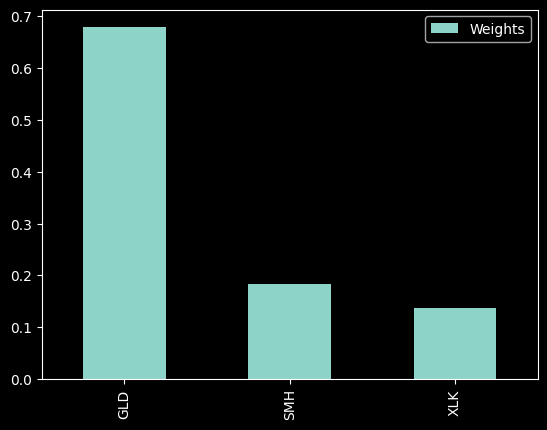

In [326]:
# Encontrar el número de activos
n = df_portfolio.shape[1]
# Inicialización de los pesos
x0=np.ones(n) / n
# Restricciones del problema de optimización
cons = [{'type': 'eq',
         'fun': lambda x: sum(abs(x))-1}]
# Establecer los límites
Bounds = [(0, 1) for i in range(0, n)]
# Resolución de los problemas de optimización
res = minimize(SR_criterion, x0, 
                  method = 'SLSQP',
                  args=(df_portfolio),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
# De los activos seleccionados, selecciono los que más pesos tengan en la cartera
df_weights = pd.DataFrame(res.x, index=list_tickers, columns=['Weights'])
df_weights = df_weights.loc[(df_weights["Weights"] > np.mean(df_weights["Weights"].values))]
# Reescalar
df_weights["Weights"] = df_weights["Weights"] / df_weights["Weights"].abs().sum()
df_weights.plot(kind='bar')

<Axes: >

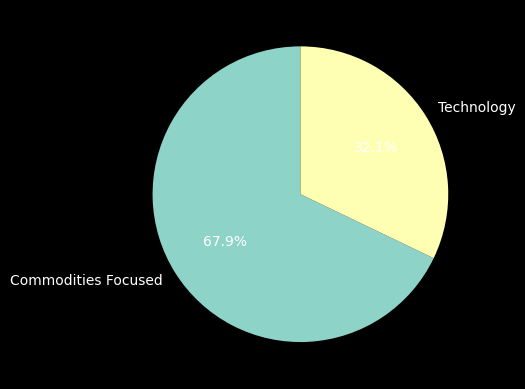

In [329]:
# Visualización de la distribución sectorial
tickers = yf.Tickers(df_weights.index.to_list())
tickers_type = dict()
for key, value in tickers.tickers.items():
    tickers_type[key] = value.info['category']
tickers_category = pd.DataFrame.from_dict(tickers_type, orient='index', columns=['category'])
df_category_weight = pd.concat([tickers_category, df_weights], axis=1)
df_category_weight.groupby('category').sum()['Weights'].plot(kind='pie', 
                                                             autopct='%1.1f%%', 
                                                             startangle=90, 
                                                             ylabel='')

<Axes: title={'center': 'Beta: 0.46 | Alpha: 0.09'}, xlabel='Tiempo anualizado', ylabel='Retornos %'>

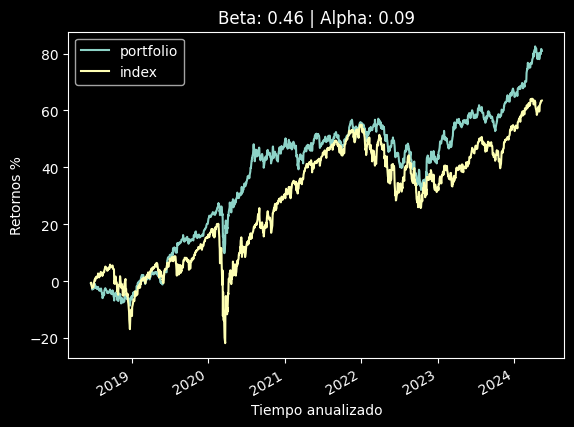

In [327]:
# Cálculo de los valores CAMP de la cartera
beta = beta_function(df_weights, df_portfolio, df_index)
alpha = alpha_function(df_weights, df_portfolio, df_index)
# Visualización del rendimiento
df_port_rend = total_portfolio(df_weights, df_portfolio)
df_port_index = pd.concat([df_port_rend, df_index], axis=1).cumsum(axis=0).multiply(100., axis=0).dropna()
df_port_index.plot(
    title=f"Beta: {beta:.2f} | Alpha: {alpha:.2f}",
    ylabel="Retornos %",
    xlabel="Tiempo anualizado")


    __________________________________________________
    Portfolio: 
	GLD: 67.87%
	SMH: 18.43%
	XLK: 13.70%
    __________________________________________________
    Beta: 0.46
    Alpha: 0.09
    Sharpe: 0.959
    Sortino: 1.308
    ___________________________________________________
    VaR: -9.871
    cVaR: -15.899
    ___________________________________________________
    


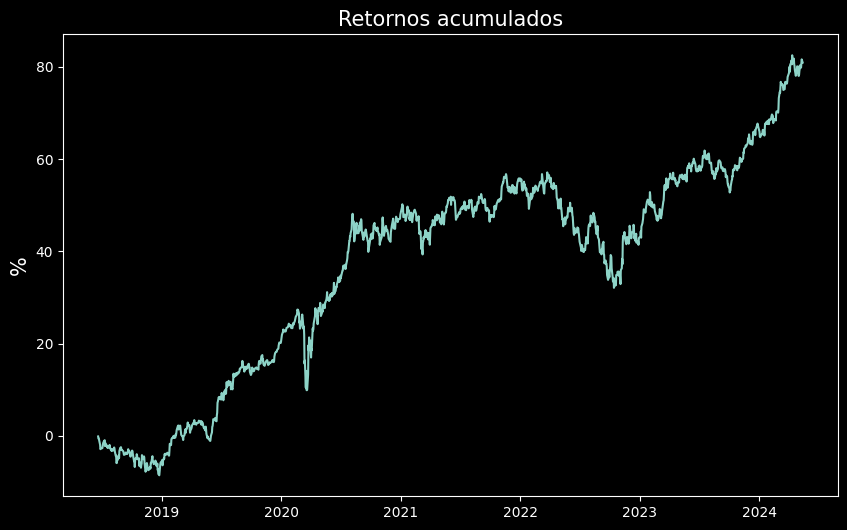

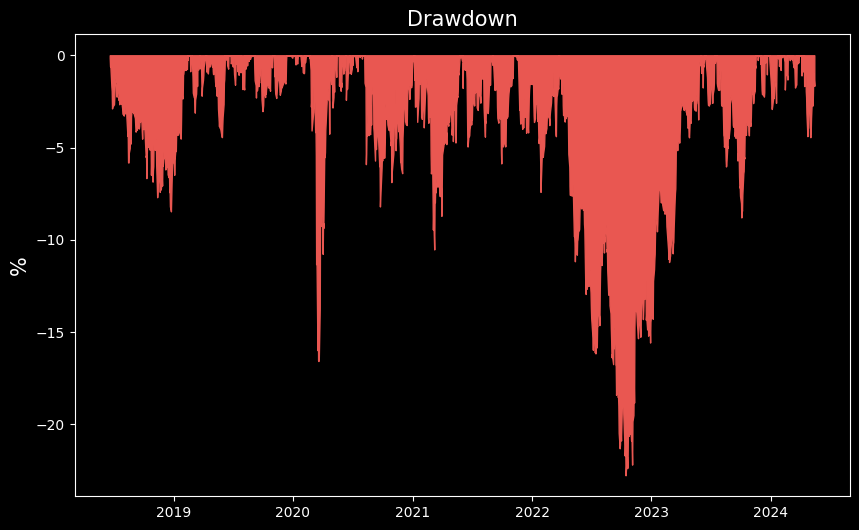

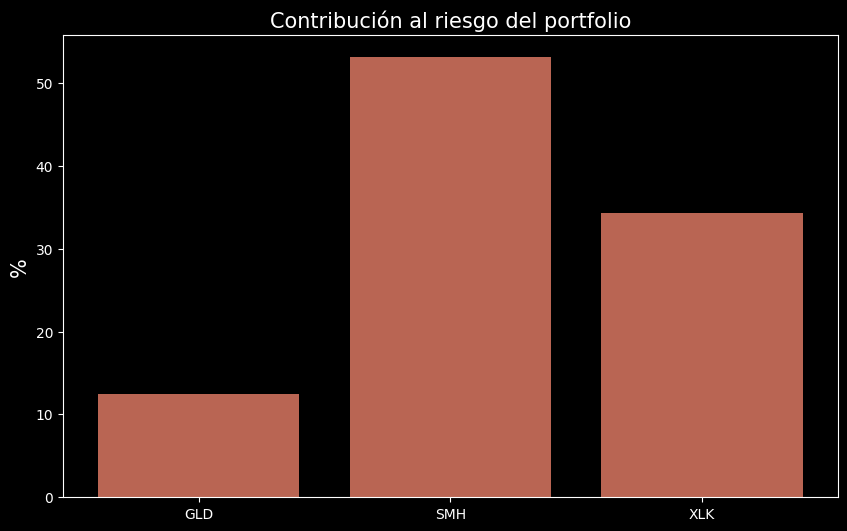

In [328]:
# Todo en una sola función
backtest_function(df_weights, df_portfolio, df_index)